# QPyTorch regression with derivative information

## Introduction
In this notebook, we show how to train a QEP regression model in QPyTorch of an unknown function given function value and derivative observations. We consider modeling the function:

$$
\begin{align}
              y &= \begin{cases} 1.5x, & x\in [0,1] \\
                                 3.5-2x, & x\in (1,1.5]\\
                                 3x-4, & x\in (1.5,2]\\
                    \end{cases} \qquad + \epsilon \\
  \frac{dy}{dx} &= \begin{cases} 1.5, & x\in [0,1] \\
                                 -2, & x\in (1,1.5]\\
                                 3, & x\in (1.5,2\\
                    \end{cases} \qquad + \epsilon \\  
       \epsilon &\sim \mathcal{N}(0, 0.1^2)
\end{align}
$$

using 50 value and derivative observations.

In [1]:
import torch
import qpytorch
import math
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Setting up the training data
We use 50 uniformly distributed points in the interval $[0, 5 \pi]$

In [2]:
lb, ub = 0.0, 2.0
n = 50

f = {'fun': lambda ts: torch.tensor([1.5*t*(t>=0 and t<=1) + (3.5-2*t)*(t>1 and t<=1.5) + (3*t-4)*(t>1.5 and t<=2) for t in ts]),
     'diff': lambda ts: torch.tensor([1.5*(t>=0 and t<=1) - 2*(t>1 and t<=1.5) + 3*(t>1.5 and t<=2) for t in ts])}

train_x = torch.linspace(lb, ub, n).unsqueeze(-1)
train_y = torch.stack([
    f['fun'](train_x),
    f['diff'](train_x)
], -1).squeeze(1)

train_y += 0.1 * torch.randn(n, 2)

## Setting up the model
A QEP prior on the function values implies a multi-output QEP prior on the function values and the partial derivatives, see 9.4 in http://www.gaussianprocess.org/gpml/chapters/RW9.pdf for more details. This allows using a `MultitaskMultivariateQExponential` and `MultitaskQExponentialLikelihood` to train a QEP model from both function values and gradients. The resulting Matern32 kernel that models the covariance between the values and partial derivatives has been implemented in `Matern32KernelGrad` and the extension of a constant mean is implemented in `ConstantMeanGrad`.

The `Matern32KernelGrad` is generally worse conditioned than the `Matern32Kernel`, so we place a lower bound on the noise parameter to keep the smallest eigenvalues of the kernel matrix away from zero.

In [3]:
POWER = 1.0
class QEPModelWithDerivatives(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super(QEPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMeanGrad()
        self.base_kernel = qpytorch.kernels.Matern32KernelGrad()
        self.covar_module = qpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultitaskMultivariateQExponential(mean_x, covar_x, power=self.power)

likelihood = qpytorch.likelihoods.MultitaskQExponentialLikelihood(num_tasks=2, power=torch.tensor(POWER))  # Value + Derivative
model = QEPModelWithDerivatives(train_x, train_y, likelihood)

The model training is similar to training a standard QEP regression model

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes QExponentialLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))        
    optimizer.step()

Iter 1/50 - Loss: 2.096   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 2.061   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 2.029   lengthscale: 0.758   noise: 0.598
Iter 4/50 - Loss: 1.997   lengthscale: 0.746   noise: 0.554
Iter 5/50 - Loss: 1.967   lengthscale: 0.728   noise: 0.513
Iter 6/50 - Loss: 1.938   lengthscale: 0.714   noise: 0.474
Iter 7/50 - Loss: 1.911   lengthscale: 0.712   noise: 0.438
Iter 8/50 - Loss: 1.885   lengthscale: 0.722   noise: 0.403
Iter 9/50 - Loss: 1.859   lengthscale: 0.740   noise: 0.371
Iter 10/50 - Loss: 1.834   lengthscale: 0.764   noise: 0.341
Iter 11/50 - Loss: 1.810   lengthscale: 0.791   noise: 0.313
Iter 12/50 - Loss: 1.786   lengthscale: 0.819   noise: 0.287
Iter 13/50 - Loss: 1.762   lengthscale: 0.846   noise: 0.263
Iter 14/50 - Loss: 1.739   lengthscale: 0.873   noise: 0.241
Iter 15/50 - Loss: 1.716   lengthscale: 0.898   noise: 0.220
Iter 16/50 - Loss: 1.692   lengthscale: 0.922   noise: 0.201
Iter 17/50 - Loss: 1.669   length

Model predictions are also similar to GP regression with only function values, butwe need more CG iterations to get accurate estimates of the predictive variance

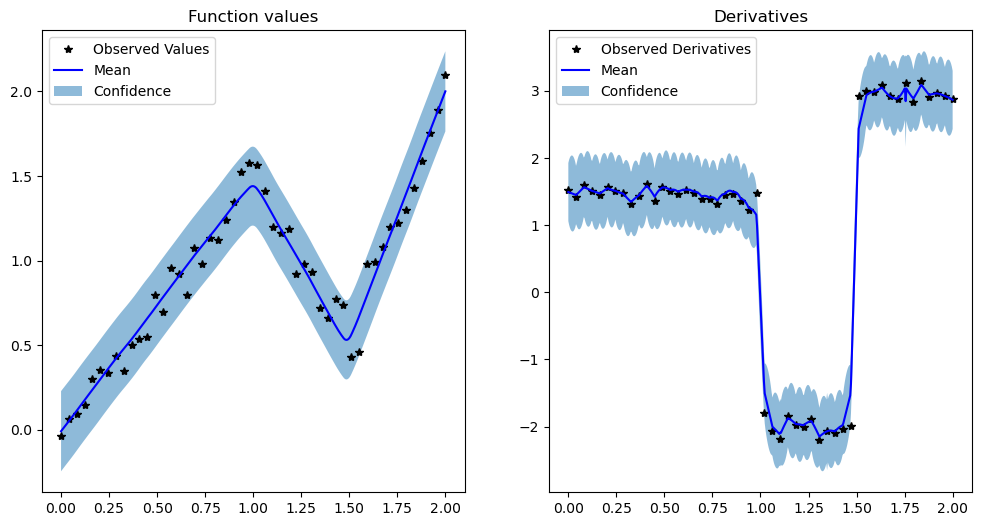

In [5]:
# Set into eval mode
model.train()
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Make predictions
with torch.no_grad(), qpytorch.settings.max_cg_iterations(50):
    test_x = torch.linspace(lb, ub, 500)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
y1_ax.set_title('Function values')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
y2_ax.set_title('Derivatives')

None